📂 正在读取数据: ../logs/main_case/evaluation_results.csv
✅ 成功加载 132 条记录。


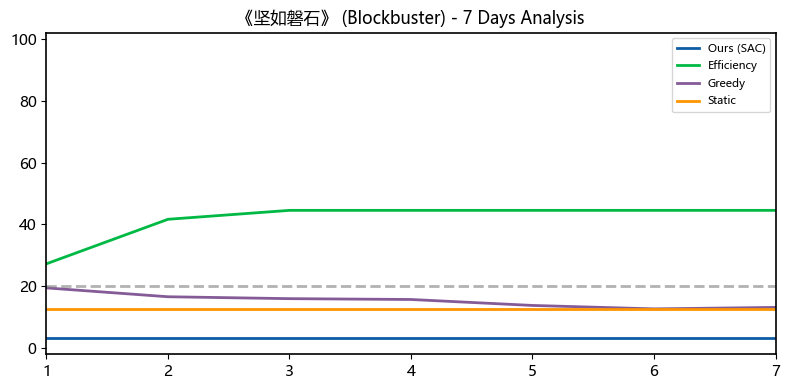

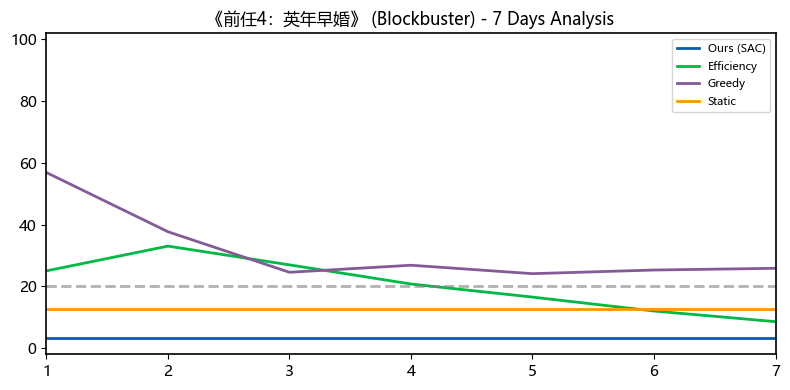

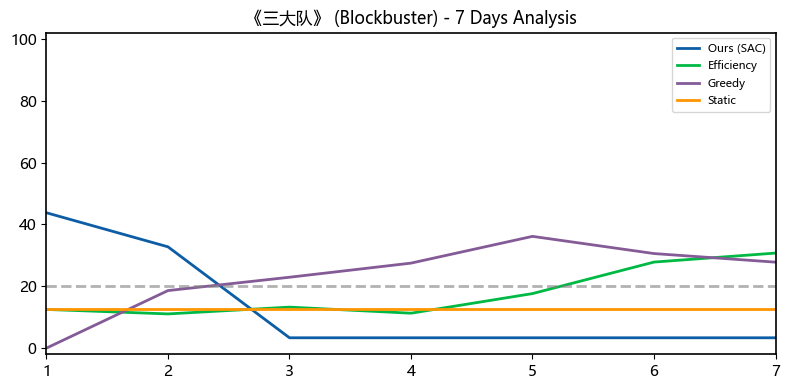

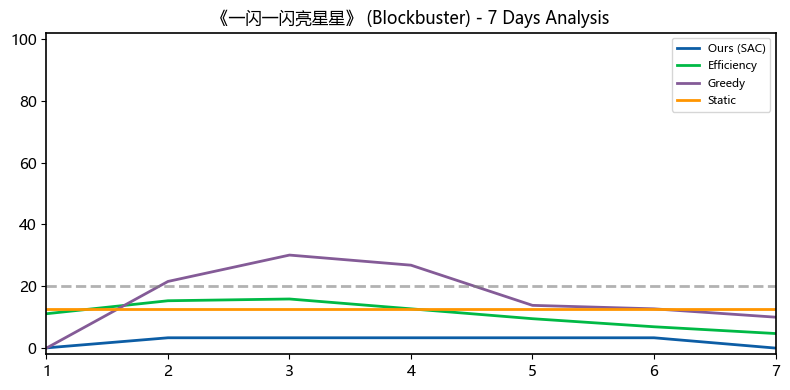

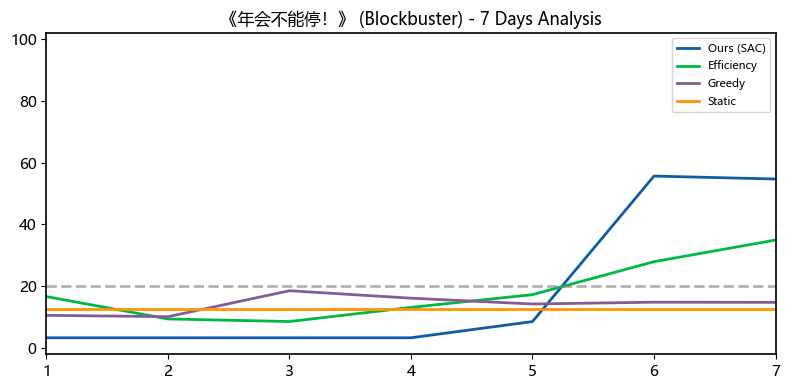

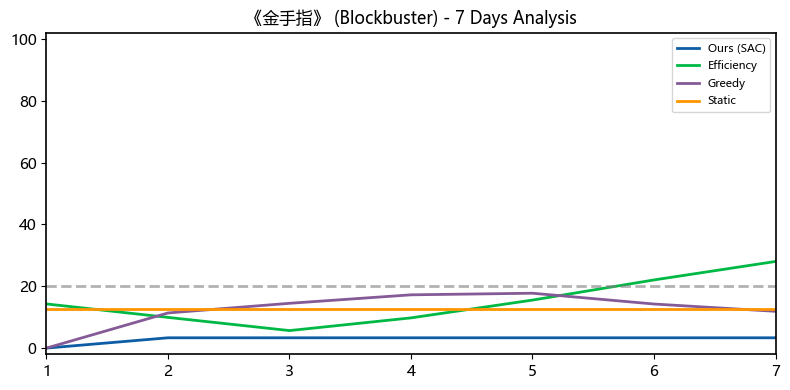

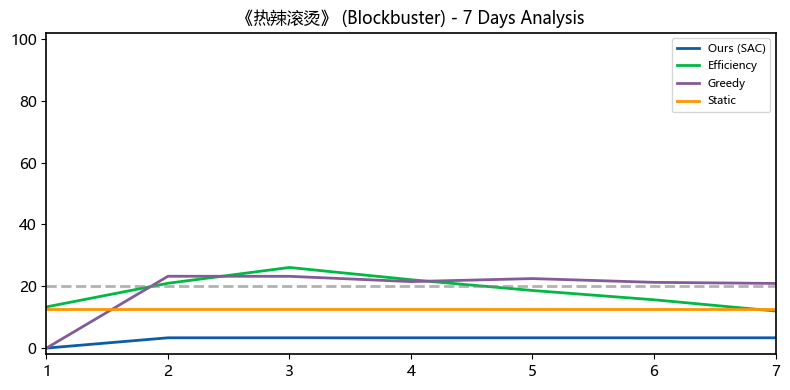

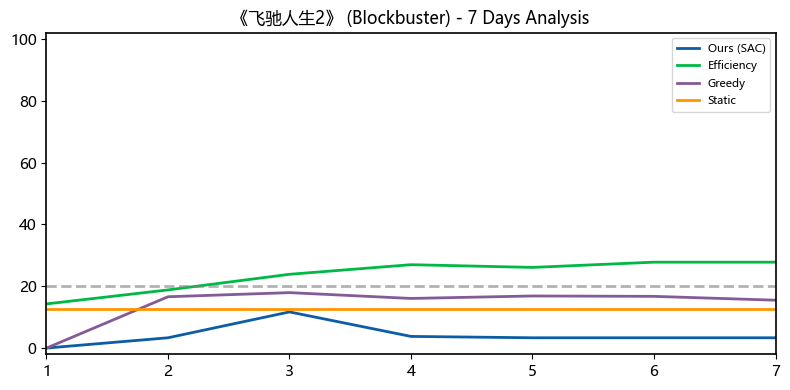

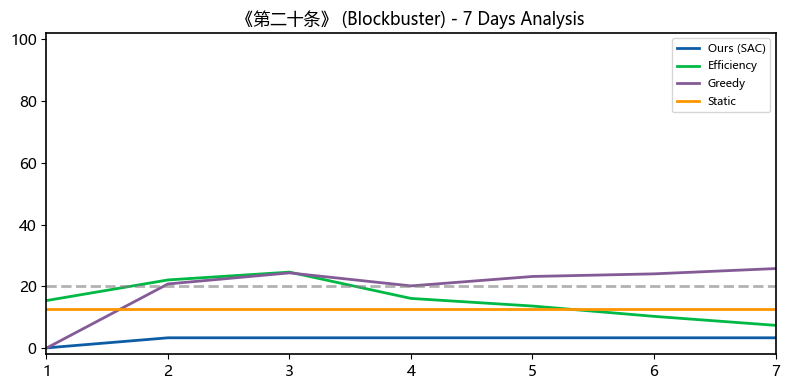

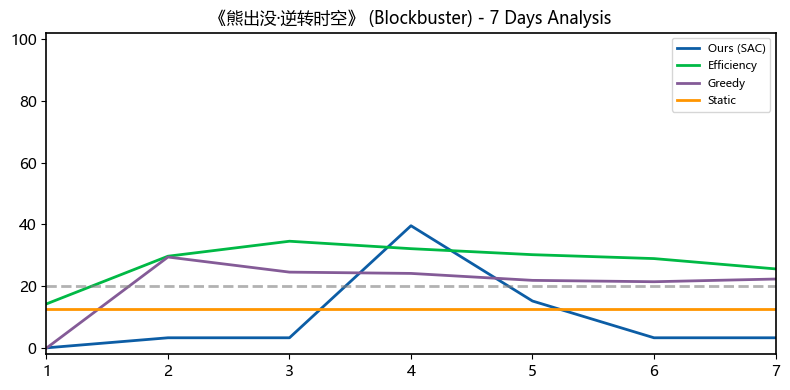

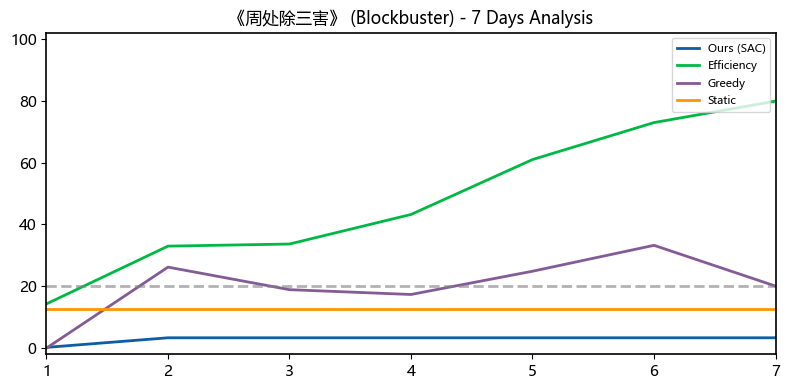

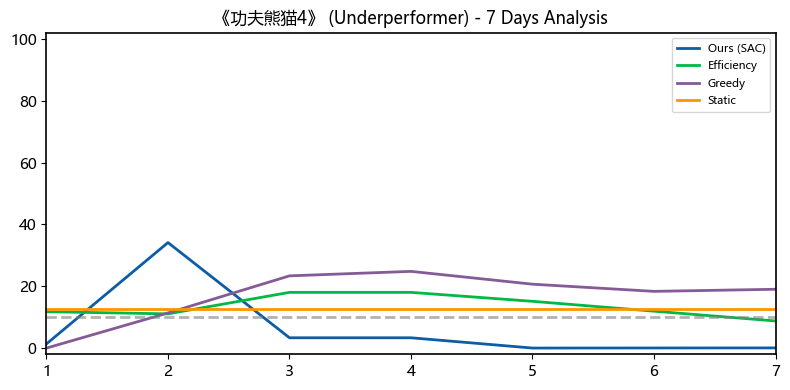

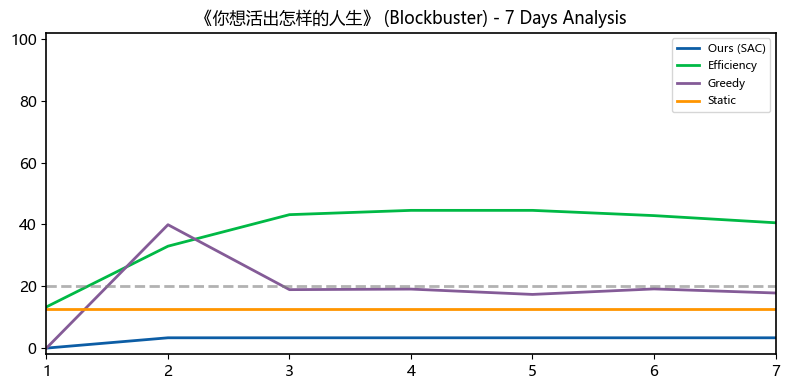

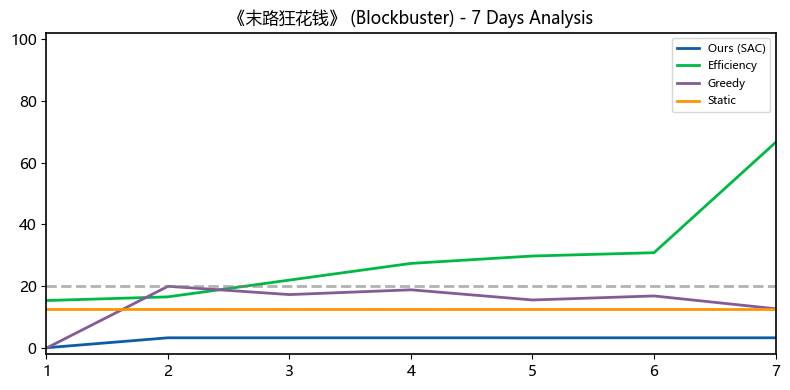

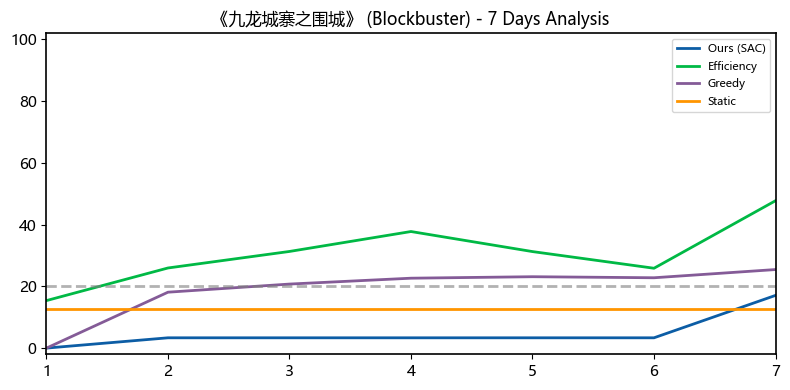

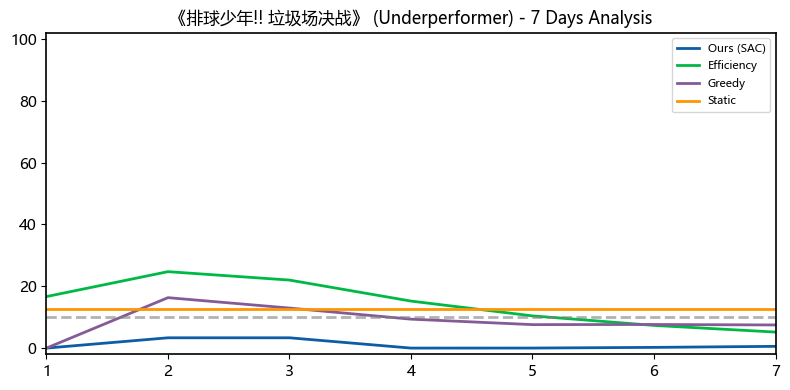

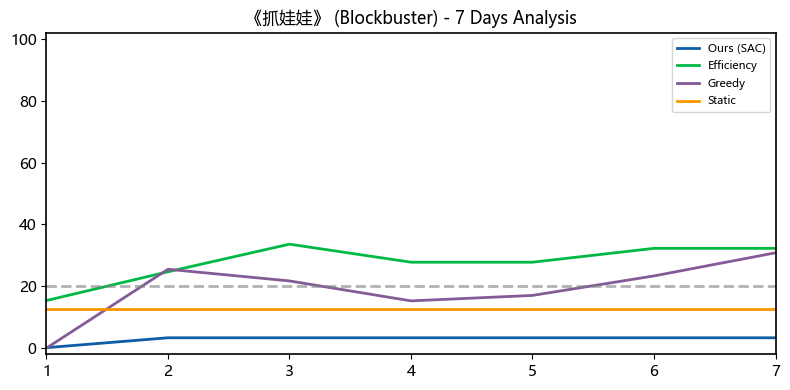

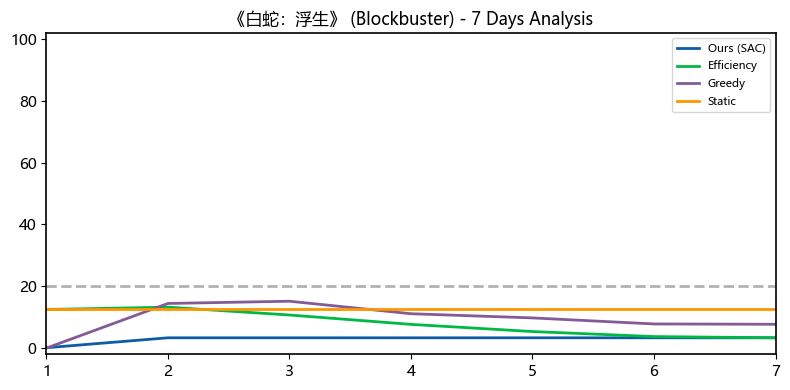

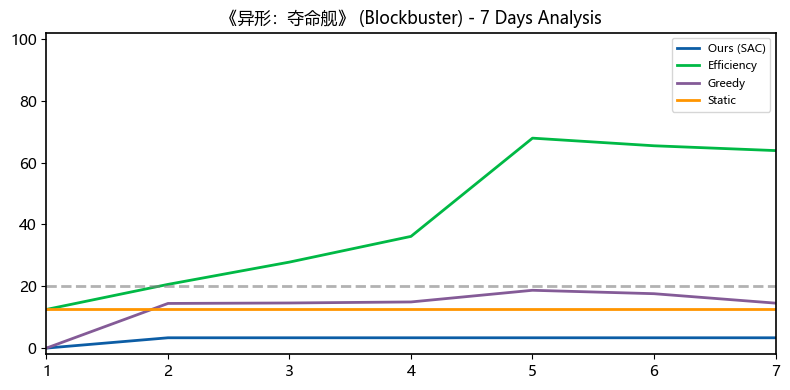

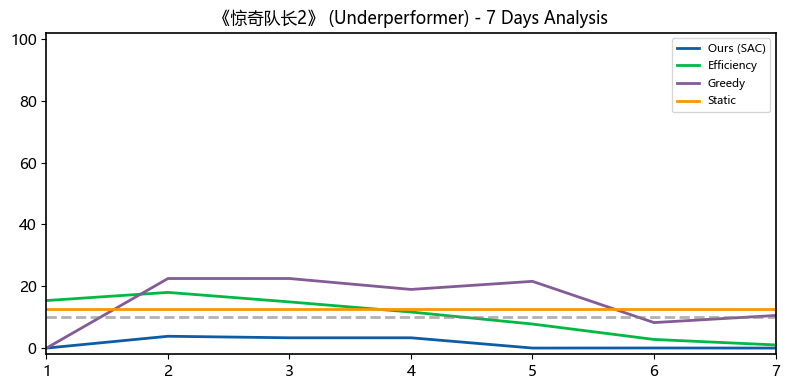

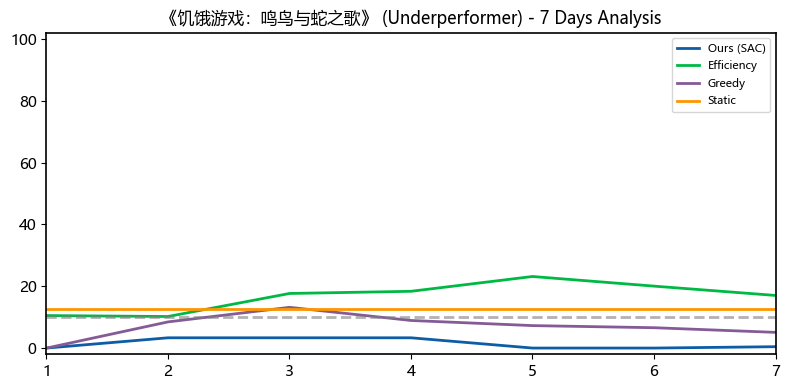

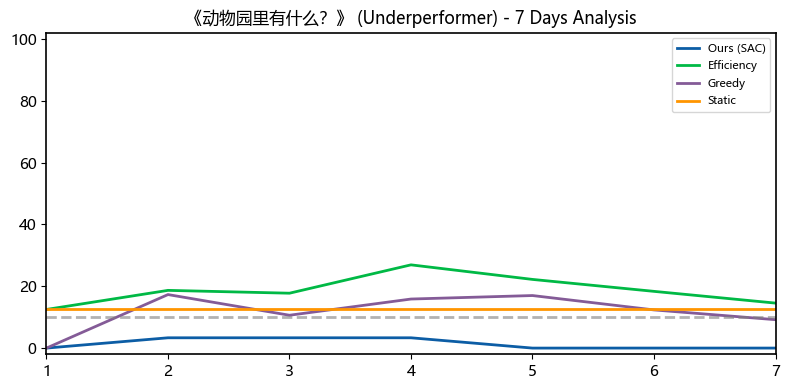

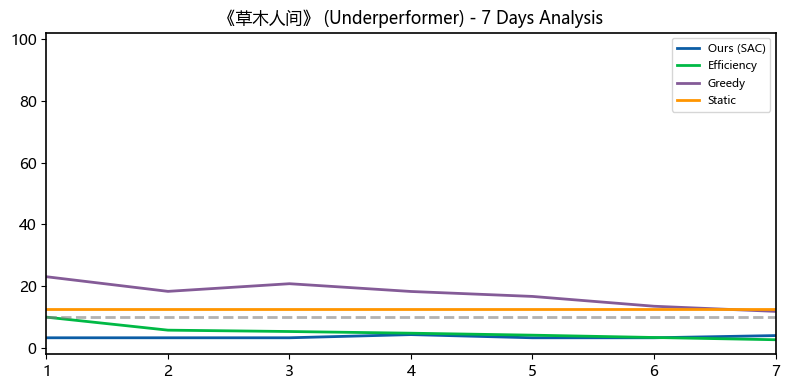

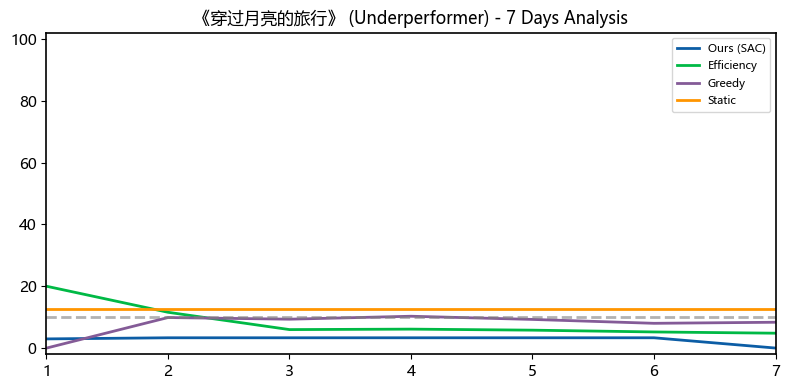

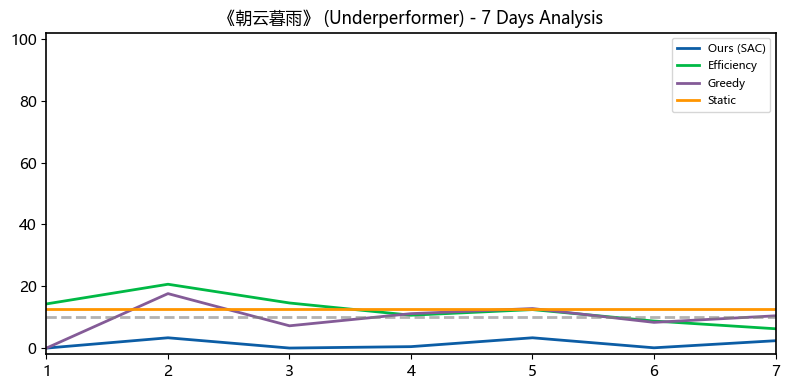

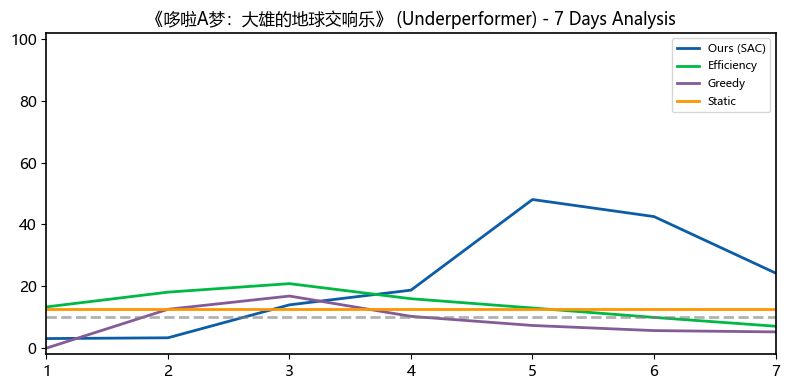

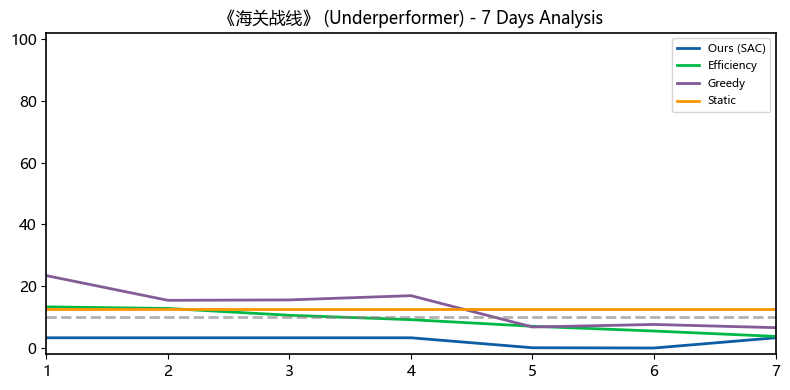

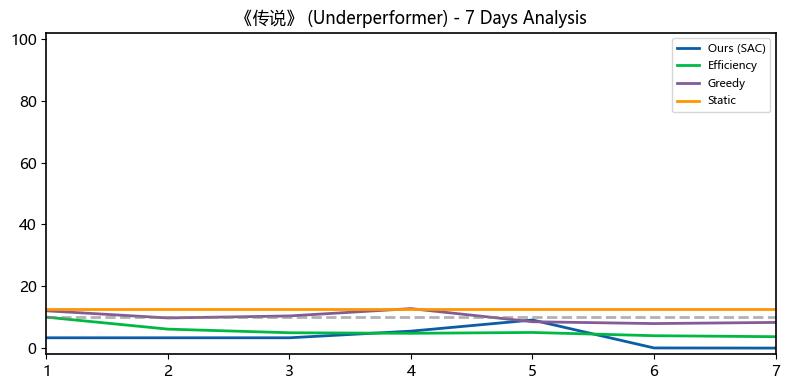

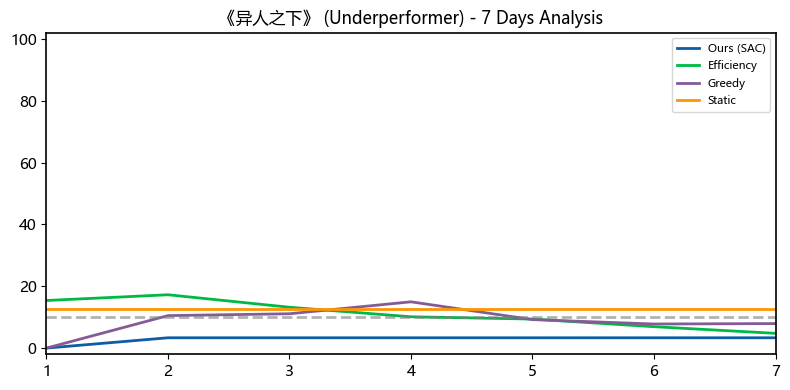

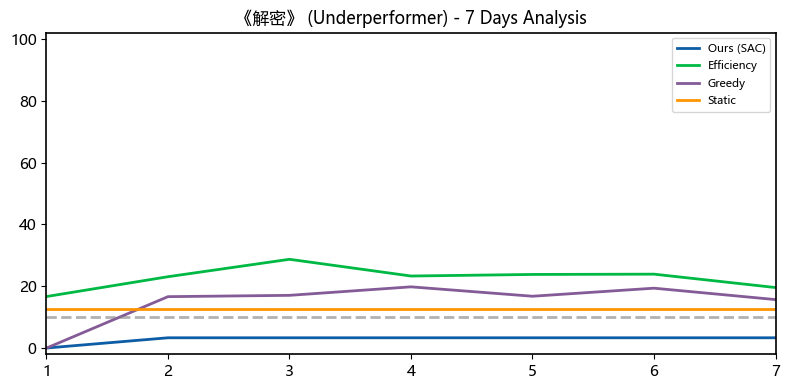

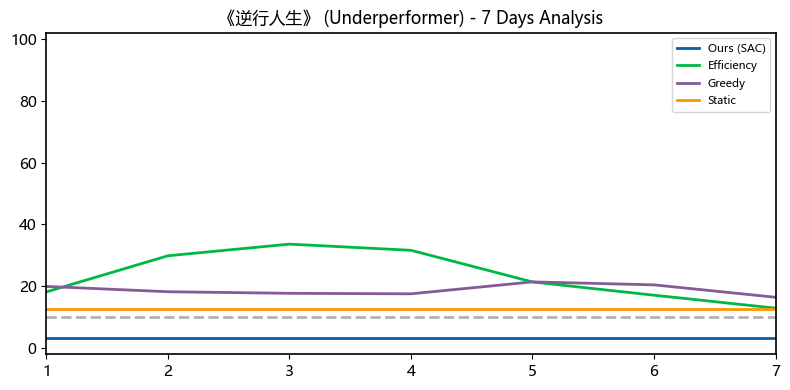

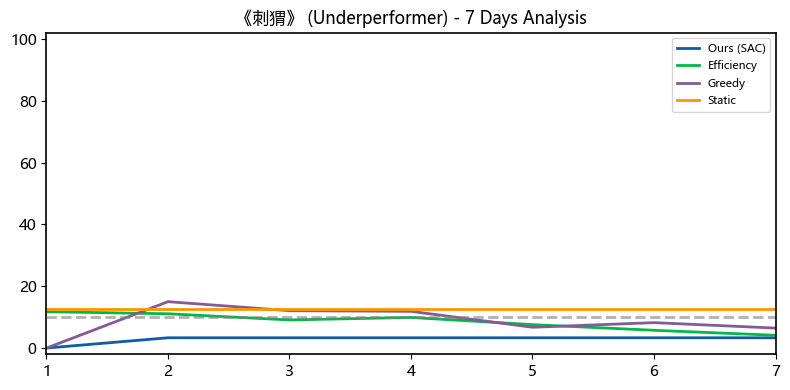


                         策略捕捉/止损天数总表 (观察期: 7天, 未达标记为7)                          
            类别            影片  Ours (SAC)  Efficiency  Greedy  Static
   Blockbuster          坚如磐石           7           1       7       7
   Blockbuster      前任4：英年早婚           7           1       1       7
   Blockbuster           三大队           1           6       3       7
   Blockbuster       一闪一闪亮星星           7           7       2       7
   Blockbuster        年会不能停！           6           6       7       7
   Blockbuster           金手指           7           6       7       7
   Blockbuster          热辣滚烫           7           2       2       7
   Blockbuster         飞驰人生2           7           3       7       7
   Blockbuster          第二十条           7           2       2       7
   Blockbuster      熊出没·逆转时空           4           2       2       7
   Blockbuster         周处除三害           7           2       2       7
Underperformer         功夫熊猫4           1           7       1       7
   Blockbuster     你想

C:\Users\86155\AppData\Local\Temp\ipykernel_19468\4132149380.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(plot_data, labels=["SAC", "Eff", "Greedy", "Stat"], patch_artist=True)
C:\Users\86155\AppData\Local\Temp\ipykernel_19468\4132149380.py:192: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[i].boxplot(plot_data, labels=["SAC", "Eff", "Greedy", "Stat"], patch_artist=True)


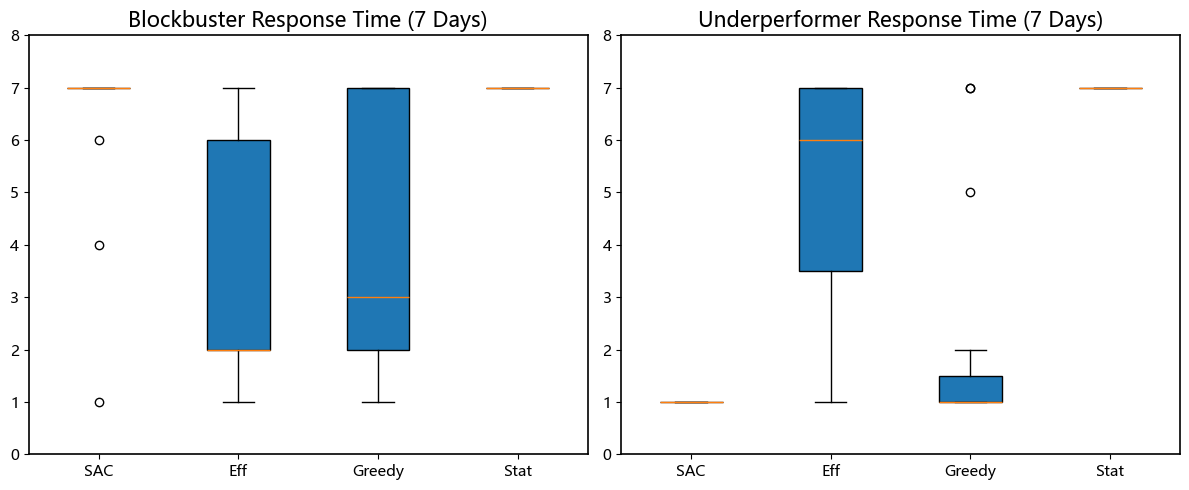

In [8]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import os
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
import sys
import platform

# ==============================================================================
# 0. 全局配置
# ==============================================================================
def set_pub_style():
    sys_name = platform.system()
    if sys_name == "Windows":
        font_list = ['Microsoft YaHei', 'SimHei', 'Arial', 'sans-serif']
    elif sys_name == "Darwin":
        font_list = ['PingFang SC', 'Heiti TC', 'Arial Unicode MS', 'Arial', 'sans-serif']
    else:
        font_list = ['WenQuanYi Micro Hei', 'Noto Sans CJK SC', 'SimHei', 'Arial', 'sans-serif']
        
    plt.rcParams['font.family'] = ['sans-serif']
    plt.rcParams['font.sans-serif'] = font_list
    plt.rcParams['axes.unicode_minus'] = False
    plt.rcParams['figure.dpi'] = 100

COLOR_PALETTE = {
    "SAC": "#0C5DA5", "Efficiency": "#00B945", "Greedy": "#845B97", "Static": "#FF9500", "Ref": "#7F7F7F"
}

# ==============================================================================
# 1. 同步电影名单 (20+20)
# ==============================================================================
BLOCKBUSTER_MOVIES = [
    '坚如磐石', '前任4：英年早婚', '莫斯科行动', '涉过愤怒的海', '三大队', '一闪一闪亮星星', 
    '年会不能停！', '金手指', '热辣滚烫', '飞驰人生2', '第二十条', '熊出没·逆转时空', 
    '周处除三害', '你想活出怎样的人生', '末路狂花钱', '九龙城寨之围城', '我才不要和你做朋友呢', 
    '抓娃娃', '白蛇：浮生', '异形：夺命舰'
]

UNDERPERFORMER_MOVIES = [
    '惊奇队长2', '饥饿游戏：鸣鸟与蛇之歌', '我没谈完的那场恋爱', '紧急救援', '离军记', 
    '动物园里有什么？', '功夫熊猫4', '草木人间', '穿过月亮的旅行', '朝云暮雨', 
    '分歧者：异类觉醒', '哆啦A梦：大雄的地球交响乐', '排球少年!! 垃圾场决战', '海关战线', 
    '传说', '异人之下', '解密', '逆行人生', '刺猬', '出走的决心'
]

# ==============================================================================
# 2. 数据加载
# ==============================================================================
def load_data(csv_path='../logs/main_case/evaluation_results.csv'):
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    except NameError:
        current_dir = os.getcwd()

    possible_paths = [
        csv_path, 
        os.path.join(current_dir, csv_path),
        os.path.join(current_dir, 'logs', 'main_case', 'evaluation_results.csv')
    ]
    
    found_path = None
    for p in possible_paths:
        if os.path.exists(p):
            found_path = p
            break
            
    if not found_path:
        print(f"❌ 错误：在以下路径均未找到数据文件:\n{possible_paths}")
        return pd.DataFrame()

    print(f"📂 正在读取数据: {found_path}")
    try:
        df = pd.read_csv(found_path, encoding='utf-8')
    except UnicodeDecodeError:
        df = pd.read_csv(found_path, encoding='gbk')

    for col in ['daily_actions', 'daily_incomes']:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: json.loads(x) if isinstance(x, str) else x)
    
    if 'case_study_index' in df.columns:
        df['case_study_index'] = pd.to_numeric(df['case_study_index'], errors='coerce')

    print(f"✅ 成功加载 {len(df)} 条记录。")
    return df

# ==============================================================================
# 3. 绘图与天数统计
# ==============================================================================
def analyze_and_plot(df, plots_dir):
    unique_cases = df[['start_date', 'case_study_movie']].drop_duplicates()
    OBSERVE_DAYS = 7  # 【修改】只看前7天
    
    detailed_table = []
    stats_data = {"Blockbuster": {}, "Underperformer": {}}

    for _, row in unique_cases.iterrows():
        date = row['start_date']
        movie = row['case_study_movie']
        
        if movie in BLOCKBUSTER_MOVIES:
            category, threshold_val = "Blockbuster", 20.0
        elif movie in UNDERPERFORMER_MOVIES:
            category, threshold_val = "Underperformer", 10.0
        else: continue

        case_df = df[(df['start_date'] == date) & (df['case_study_movie'] == movie)].copy()
        fig, ax = plt.subplots(figsize=(8, 4))
        
        policy_res = {"类别": category, "影片": movie}
        
        policy_order = ["RL (SAC)", "效率启发式策略", "贪婪启发式策略", "静态启发式策略"]
        display_names = ["Ours (SAC)", "Efficiency", "Greedy", "Static"]

        for p_name, d_name in zip(policy_order, display_names):
            if p_name not in case_df['policy'].values: 
                policy_res[d_name] = "-"
                continue
            
            run = case_df[case_df['policy'] == p_name].iloc[0]
            if pd.isna(run['case_study_index']): continue
            
            idx = int(run['case_study_index'])
            actions = run['daily_actions']
            y_vals = [act[idx] * 100 for act in actions[:OBSERVE_DAYS]]
            x_vals = range(1, len(y_vals) + 1)
            
            # 绘图
            ax.plot(x_vals, y_vals, label=d_name, 
                    color=COLOR_PALETTE[d_name.split(' ')[0] if '(' not in d_name else "SAC"], 
                    linewidth=2)
            
            # 【修改】计算天数：7天未达标则显示7
            day_hit = OBSERVE_DAYS
            for d_idx, val in enumerate(y_vals):
                if (category == "Blockbuster" and val >= threshold_val) or \
                   (category == "Underperformer" and val <= threshold_val):
                    day_hit = d_idx + 1
                    break
            
            policy_res[d_name] = day_hit
            if d_name not in stats_data[category]: stats_data[category][d_name] = []
            stats_data[category][d_name].append(day_hit)

        detailed_table.append(policy_res)

        # 装饰并保存
        ax.axhline(y=threshold_val, color="#7F7F7F", linestyle='--', alpha=0.6)
        ax.set_title(f"《{movie}》 ({category}) - 7 Days Analysis", fontsize=12)
        ax.set_ylim(-2, 102)
        ax.set_xlim(1, OBSERVE_DAYS)
        ax.set_xticks(range(1, OBSERVE_DAYS + 1))
        ax.legend(fontsize=8, loc='upper right')
        
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, f"{movie}_{category}_7d.png"))
        plt.show() 
        plt.close()

    return stats_data, detailed_table

# ==============================================================================
# 4. 执行并输出表格
# ==============================================================================
def main():
    set_pub_style()
    df = load_data()
    if df.empty: return

    plots_dir = os.path.join(os.getcwd(), 'plots', 'market_analysis_7d')
    os.makedirs(plots_dir, exist_ok=True)

    stats, detailed_list = analyze_and_plot(df, plots_dir)
    
    # 打印总表
    print("\n" + "="*85)
    print(f"{'策略捕捉/止损天数总表 (观察期: 7天, 未达标记为7)':^80}")
    print("="*85)
    final_df = pd.DataFrame(detailed_list)
    cols = ["类别", "影片", "Ours (SAC)", "Efficiency", "Greedy", "Static"]
    print(final_df[cols].to_string(index=False))
    print("="*85)

    # 绘制汇总图
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    for i, cat in enumerate(["Blockbuster", "Underperformer"]):
        plot_data = [stats[cat][p] for p in ["Ours (SAC)", "Efficiency", "Greedy", "Static"] if p in stats[cat]]
        axes[i].boxplot(plot_data, labels=["SAC", "Eff", "Greedy", "Stat"], patch_artist=True)
        axes[i].set_title(f"{cat} Response Time (7 Days)")
        axes[i].set_ylim(0, 8)
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "Overall_Summary_7d.png"))
    plt.show()

if __name__ == "__main__":
    main()